In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import subject_DM
import numpy as np
import scipy.stats

Loaded entropies from file (S=15000, entropy_bins=50)!
Loaded dot-level measures from file (S=2000, Smin=20)!


# Accumulated evidence vs. motor preparation
## Defining the motor preparation signal
We are interested in brain areas that represent the accumulated evidence for a decision - a quantity you may call cognitive. There is, however, the possibility that we mistake brain areas only exhibiting motor preparation signals as ones which accumulate evidence. The issue is that you would intuitively not assign a motor preparation signal to the cognitive domain. So it should be separate from accumulated evidence. It turns out that the differentiation between cognitive accumulated evidence and motor preparation is not easily done, even in theory. It could, for example, be that motor areas are gradually activated tracing the accumulated evidence. Then it would be impossible to dissociate the two concepts: The only difference between the two signals would perhaps be their location in traditionally cognitive or motor brain areas.

So my working hypothesis here is that motor preparation is not directly related to accumulated evidence, more specifically: the motor preparation signal does not fluctuate with any measure of evidence for a decision before the actual decision is made. This means that motor preparation signals must gradually increase under the assumption that the (cognitive) decision does not change after it has been made. So-called changes of mind indicate that people do sometimes change their decision in the course of a prolonged response movement, but this is rare (below 20%?) and it's unclear whether it can also happen before a response button is pressed. Also, if it would happen frequently and within a trial, we would be back at a signal that fluctuates with evidence assuming that the decision and following changes of mind are based on evidence and don't happen randomly. Consequently, I define motor preparation as the process during which a signal that is related to the made decision gradually increases until that decision is indicated by a motor response. 

One remaining problem is that we don't know when the underlying decision is made. Also, a potentially rational decision may be obscured by neural noise such that the final motor response does not correspond to a theoretically derived rational decision. It could be that the decision itself is noisy, or that the motor response is noisy so that sometimes a response opposite to the underlying decision is made. For discerning these scenarios I should have an estimate of the decision that is independent of the motor response, but I'm afraid that I currently don't have that, because I only know the rational decision from the stimulus, but not where to look for a possibly noisy final decision made by the brain. This means that I can only use the made motor response to define the motor preparation signal.

In summary, the motor preparation signal should gradually increase and reflect the eventual motor response from an unknown time point onwards. This still leaves a couple of open questions: First, what is this unknown time point from which the signal reflects the motor response? Second, how does the signal behave before this time point? Third, how exactly is the eventual motor response reflected in the signal? I will try to make informed guesses to resolve these questions. First, classic results about lateralised readiness potentials in EEG and MEG suggest that response-related motor preparation starts around 300 ms before the response [Gazzaniga1998]. The same evoked potentials over motor cortex suggest that before 300 ms there is a steadily increasing signal that does not differentiate between possible responses (the Bereitschaftspotential) and reaches a common plateau before the 300 ms before the response. For the sake of simplicity, I assume that the rise in motor preparation signal should be linear. This means that I need a time point from which I want the Bereitschaftspotential to rise. Following the illustration of [Gazzaniga1998, Fig. 10.25] this is another 300 ms before the start of the lateralised readiness potential at 600 ms before the eventual response. The illustration also suggests that the rise of the preparation signal stops for the unchosen option while continuing, but shallower, for the eventually made response. Arbitrarily I choose the rise for the eventually made response to be 1/3 of that for the initial Bereitschaftspotential. As I don't know anything about the absolute level that is reached by the time of the response, I set this to 1. After the response, the Bereitschaftspotential, or lateralised readiness potential, supposedly reduces to baseline, perhaps a bit faster than the original rise. I arbitrarily choose the drop of the motor preparation signal to be 1/3 faster than the rise. This leads to the following picture:

<IPython.core.display.Javascript object>


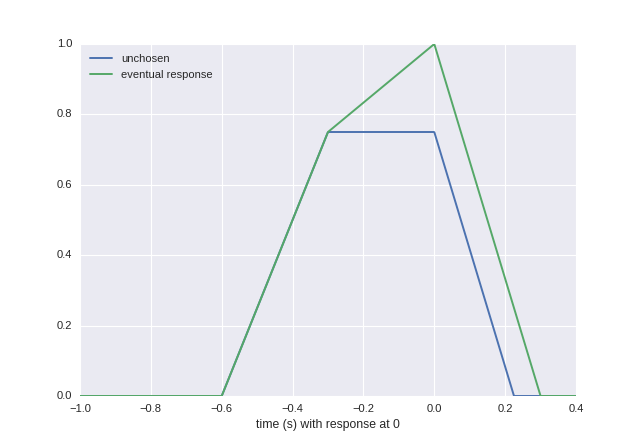

In [2]:
time = np.linspace(-1, 0.4, 1000)
mprepsig = lambda t: np.c_[np.fmax(  np.fmin(t + 0.6, 0.3) 
                                   - np.fmax(4*t/3, 0), 0), 
                           np.fmax(  np.fmin(t + 0.6, 0.3) 
                                   + np.fmin(np.fmax((t + 0.3) / 3, 0), 0.1) 
                                   - np.fmax(4*t/3, 0), 0)] / 0.4
plt.figure();
lines = plt.plot(time, mprepsig(time))
plt.legend(['unchosen', 'eventual response'], loc='upper left');
plt.xlabel('time (s) with response at 0');

## Translating into trial regressor
Now that I have defined what I expect of a motor preparation signal how can I turn this into a regressor that I can compare with the accumulated evidence regressor that I have for 100 ms time steps? The problem is that other than the previous regressors the motor preparation signal is tied to the time within a trial centred on the response. In particular, the value of the motor preparation regressor should depend on the times that are modelled in the regression and the response time of the subject. Also, the preparation signal defines two regressors: one for the eventual response and one for the unchosen option. Here's a function that returns the two regressor given a trial time:

In [3]:
RTs = subject_DM.regressors.subject_trial.RT
def mprepsig_reg(trt):
    return pd.DataFrame(mprepsig(trt - RTs.values), index=RTs.index, columns=['mprep_uncho', 'mprep_resp'])

Given the plot above we can already guess that the two regressors are highly correlated. This is also the case:

In [4]:
mprepsig_reg(0.9).corr()

,mprep_uncho,mprep_resp
mprep_uncho,1.000000,0.961905
mprep_resp,0.961905,1.000000


I evaluated at trial time = 0.9, because that's the latest time point I investigate in the regression analysis. Because I'm more interested in the full motor preparation signal, I continue with the one for the eventually chosen response, but with the high correlation this should not matter.

## Comparison with accumulated evidence
Now the interesting part is to see in how far the motor preparation signal could explain the rationally accumulated evidence, i.e., I wonder how specific the accumulated evidence regressor is in my analysis. To test this I will simply compute the correlation of the two regressors. The lower that is, the more specific they are separately. I need to compute the correlation within subject, because the regression analysis is run within subject.

In [5]:
DM = subject_DM.get_trial_DM([1, 2, 3], r_names=['accev'])

In [6]:
times = np.linspace(0, 0.9, 91)
subjects = DM.index.levels[0]
corrs = pd.concat(
    [pd.DataFrame([np.corrcoef(np.c_[mprepsig_reg(t).mprep_resp.loc[sub], DM.loc[sub]], rowvar=0)[1:, 0]
                   for t in times], index=pd.Index(times, name='time after first dot onset (s)'), 
                   columns=DM.columns) for sub in subjects], 
    keys=subjects, names=['subject', 'time after first dot onset (s)'])
corrs.head()

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


accev_1   accev_2   accev_3
subject time after first dot onset (s)                                  
2       0.00                           -6.260106e-17  0.034706  0.059723
        0.01                            1.524051e-16  0.034706  0.059723
        0.02                            2.923523e-17  0.034706  0.059723
        0.03                           -1.153754e-16  0.034706  0.059723
        0.04                           -4.919993e-17  0.034706  0.059723

The RuntimeWarning about invalid values in division is because the motor preparation signal is 0 in all trials for early time points for some subjects. 

How high are correlations in the worst case?

<IPython.core.display.Javascript object>


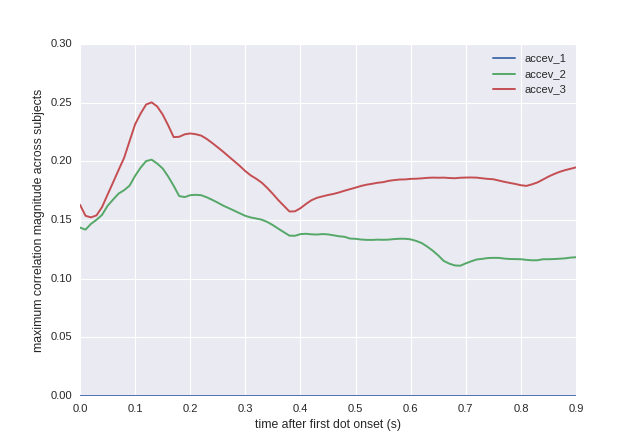

In [7]:
ax = corrs.abs().max(level='time after first dot onset (s)').plot.line()
ax.set_ylabel('maximum correlation magnitude across subjects');

And on average?

<IPython.core.display.Javascript object>


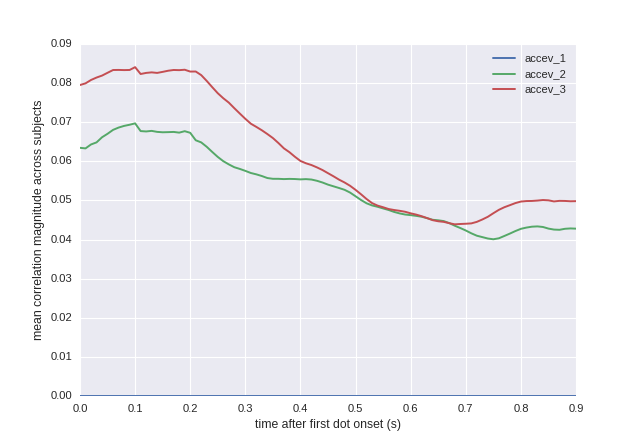

In [8]:
ax = corrs.abs().mean(level='time after first dot onset (s)').plot.line()
ax.set_ylabel('mean correlation magnitude across subjects');

Overall accumulated evidence and the motor preparation signal are only weakly correlated with an average correlation magnitude below 0.1, but also the maximum correlation magnitudes are not too high with values around 0.25. It is a bit strange that the time point of this maximum correlation magnitude is quite early at 130 ms after first dot onset. This value is reached for accev_3 which anyway cannot come into effect before 200 ms after first dot onset and must go away in the sequential analysis, as I will check below.

First, I check which subjects exhibit relatively high correlations and what the corresponding time courses are:

In [9]:
corrs.accev_3.abs().sort_values(ascending=False).dropna().ix[:60]

subject  time after first dot onset (s)
6        0.13                              0.250262
         0.12                              0.248435
         0.14                              0.246786
         0.11                              0.240759
         0.15                              0.239919
         0.10                              0.231573
         0.16                              0.230677
9        0.20                              0.223752
         0.21                              0.223133
         0.19                              0.223023
         0.22                              0.221906
         0.18                              0.220907
6        0.17                              0.220642
9        0.23                              0.219083
6        0.09                              0.217301
9        0.17                              0.217177
         0.24                              0.215598
         0.16                              0.212323
         0.25           

<IPython.core.display.Javascript object>


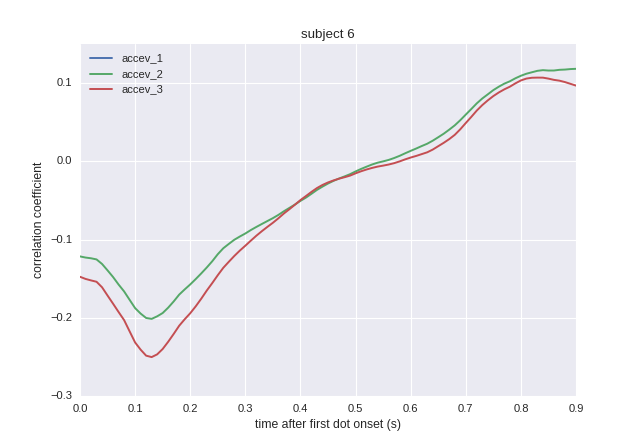

In [10]:
sub = 6
ax = corrs.loc[sub].plot.line()
ax.set_title('subject %d' % sub);
ax.set_ylabel('correlation coefficient');

In [11]:
(mprepsig_reg(0.13).loc[6, 'mprep_resp'] == 0).sum()

430

So the high correlation with accumulated evidence in subject 6 at 130 ms is based on only 50 trials as in the remaining 430 trials the motor preparation signal is 0, as expected for such an early time point.

### sequential analysis
This takes into account that accumulated evidence 1, 2 and 3 come into effect 100 ms after each other.

In [12]:
times = np.linspace(0, 0.7, 71)
corrs = pd.concat(
    [pd.DataFrame([np.corrcoef(np.c_[np.r_[mprepsig_reg(t).mprep_resp.loc[sub],
                                           mprepsig_reg(t+0.1).mprep_resp.loc[sub],
                                           mprepsig_reg(t+0.2).mprep_resp.loc[sub]], 
                                     DM.loc[sub].stack().reorder_levels([1, 0]).sort_index()], rowvar=0)[1:, 0]
                   for t in times], index=pd.Index(times, name='time after first dot onset (s)'), 
                   columns=['corrcoef']) for sub in subjects], 
    keys=subjects, names=['subject', 'time after first dot onset (s)'])
corrs.head()

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


corrcoef
subject time after first dot onset (s)          
2       0.00                            0.083099
        0.01                            0.082151
        0.02                            0.080543
        0.03                            0.078973
        0.04                            0.074866

<IPython.core.display.Javascript object>


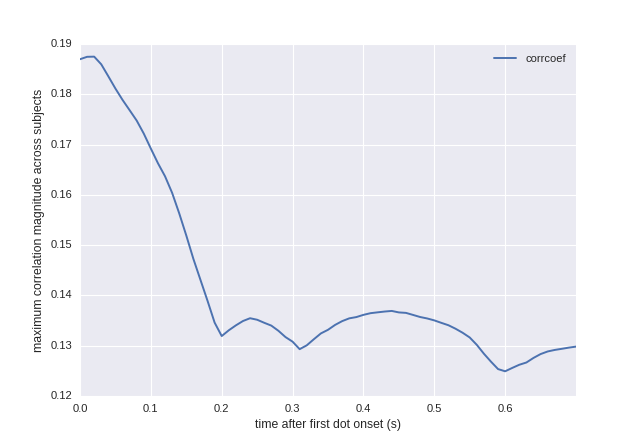

In [13]:
ax = corrs.abs().max(level='time after first dot onset (s)').plot.line()
ax.set_ylabel('maximum correlation magnitude across subjects');

And on average?

<IPython.core.display.Javascript object>


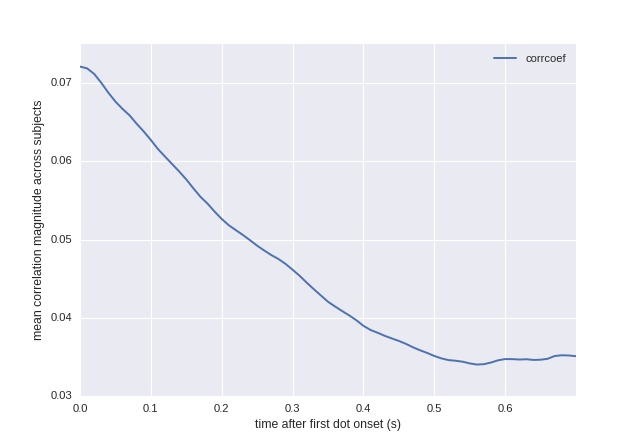

In [14]:
ax = corrs.abs().mean(level='time after first dot onset (s)').plot.line()
ax.set_ylabel('mean correlation magnitude across subjects');

So the correlations have slightly decreased in relation to the single dot analysis, but it's still the case that they are largest in the beginning of the trials. My best explanation for this is, as I have shown above, that at early time points only few trials effectively contribute to the correlation leading to larger variance in the correlation coefficients. This is then reflected in the magnitudes as they simply flip the random sign of the correlation coefficients to positive. I can check this hypothesis by computing the mean correlation coefficients respecting the signs:

<IPython.core.display.Javascript object>


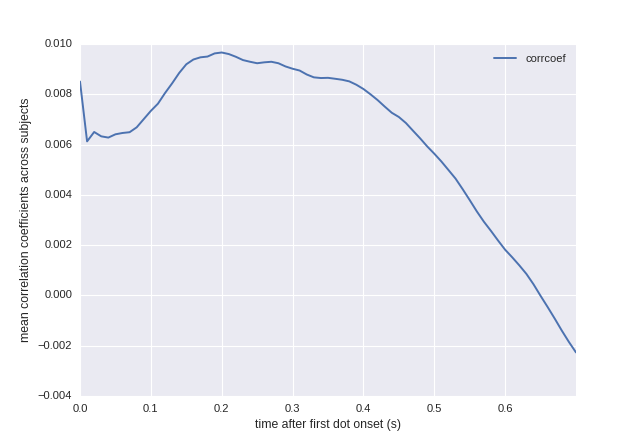

In [15]:
ax = corrs.mean(level='time after first dot onset (s)').plot.line()
ax.set_ylabel('mean correlation coefficients across subjects');

The mean correlation coefficient drops an order of magnitude which shows that there is no consistent relation between accumulated evidence and motor preparation signal across subjects. The only thing left to check is whether the correlation is reliable within subjects.

In [16]:
sub = 9

pearsonr = pd.DataFrame(
    [scipy.stats.pearsonr(np.r_[mprepsig_reg(t).mprep_resp.loc[sub],
                                mprepsig_reg(t+0.1).mprep_resp.loc[sub],
                                mprepsig_reg(t+0.2).mprep_resp.loc[sub]], 
                          DM.loc[sub].stack().reorder_levels([1, 0]).sort_index())
     for t in times], 
    index=pd.Index(times, name='time after first dot onset (s)'), 
    columns=['corrcoef', 'pval'])
pearsonr['mlog10p'] = -np.log10(pearsonr.pval)

<IPython.core.display.Javascript object>


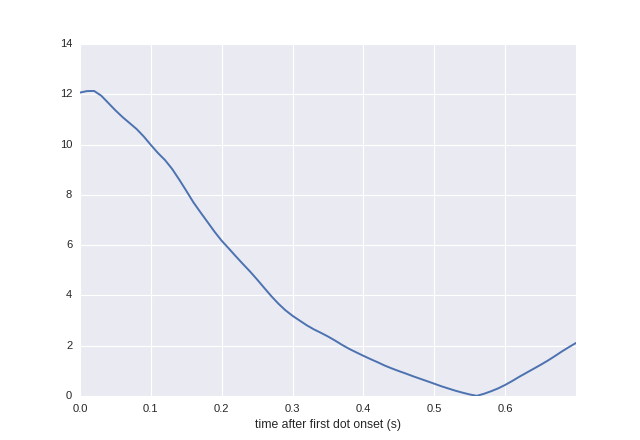

In [17]:
plt.figure()
ax = pearsonr.mlog10p.plot.line()

In contrast to what I expected, the p-values indicate that the correlations are most reliable at the high values at early time points. This, however, is the case, because scipy's p-value only takes the correlation coefficient and the number of input data points into account without a notion of effective sample size. So I now repeat the analyis, but remove all entries in the design matrix for which the motor preparation signal is 0.

In [18]:
def corr_fun(mprep, accev):
    inds = mprep != 0
    accev = np.array(accev)
    return scipy.stats.pearsonr(mprep[inds], accev[inds])

pearsonr_eff = pd.DataFrame(
    [corr_fun(np.r_[mprepsig_reg(t).mprep_resp.loc[sub],
                    mprepsig_reg(t+0.1).mprep_resp.loc[sub],
                    mprepsig_reg(t+0.2).mprep_resp.loc[sub]], 
              DM.loc[sub].stack().reorder_levels([1, 0]).sort_index())
     for t in times], 
    index=pd.Index(times, name='time after first dot onset (s)'), 
    columns=['corrcoef', 'pval'])
pearsonr_eff['mlog10p'] = -np.log10(pearsonr_eff.pval)

<IPython.core.display.Javascript object>


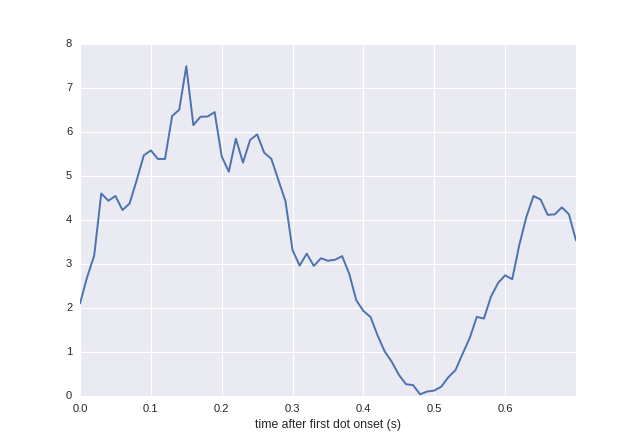

In [19]:
plt.figure()
ax = pearsonr_eff.mlog10p.plot.line()

The correlation coefficients are indeed less reliable when only the effective trials are taken into account, but I still see that early time points are most reliable with a peak around 150 ms after first dot onset. Are the actual correlation coefficients similar to the ones computed from all trials? If yes, I know that they are mostly driven by the non-zero trials.

<IPython.core.display.Javascript object>


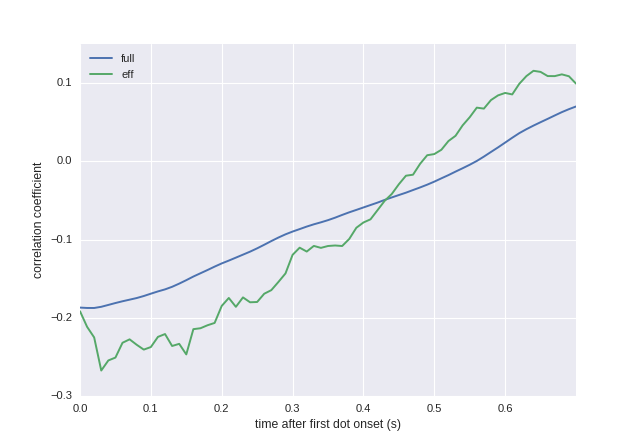

In [20]:
ax = pd.concat([pearsonr.corrcoef, pearsonr_eff.corrcoef], axis=1, keys=['full', 'eff']).plot.line()
ax.set_ylabel('correlation coefficient');

So, yes, the biggest part of the correlation seems to be driven by the non-zero trials, but how could it be different? Still, the question remains why there is a mild anti-correlation with accumulated evidence at early time points for this subject? Although a correlation at 150 ms here means that accumulated evidence for the first dot (a constant) correlates with motor preparation at 150 ms, accev for the second dot correlates with motprep at 250 ms and accev for the third dot correlates with motprep at 350 ms. Perhaps I should not worry about this too much. The overall correlations between accumulated evidence and motor preparation are small. The few subjects which show slightly elevated correlation magnitudes may simply result from randomly aligning accumulated evidence with the motor preparation signal through the random variation in response times. That correlation magnitude drop considerably when averaging across subjects speaks for that.

## Conclusion
I defined a motor preparation signal as a rising signal that drops again at the response time in that trial. I tried to make as few arbitrary assumptions as possible while representing the intuitive features belonging to such a signal. I then translated the signal into a regressor for a trial-based regression analysis and compared it to the accumulated evidence regressor I had already defined. The results show that the accumulated evidence and motor preparation regressors represent different quantities and, in particular, that it should be possible to discriminate the corresponding effects in a regression analysis. There may be some relation between accumulated evidence and motor preparation in some subjects, but it is, from all I know, likely that this only arises through random associations. Including the motor preparation signal into the regression analysis may, therefore, reduce effect sizes for accumulated evidence a bit, but without removing the major effects. Similarly, I can exclude with reasonable certainty that the already identified effects for accumulated evidence are only related to evidence-unrelated motor preparation.

# Accumulated evidence vs. dot counts
Another possible confound of accumulated evidence is simply the number of already presented dots. The principle idea is the same as for the motor preparation signal: Because accumulated evidence should, on average, rise (or drop) it should be correlated with any other measure that rises (or drops) throughout the trial. The only guard against this is that accumulated evidence may rise on average, but it doesn't need to do so in individual trials. This is what prevented a strong correlation with the motor preparation signal and it probably also ensures that accumulated evidence does not strongly correlate with the raw number of dots already presented.

## Defining a dot count measure
This is simple: For a given time point within the trial, you just return the number of dots that have already been presented up to that time point. As new dots (or rather dot positions) appear every 100 ms, you get a signal that increments every 100 ms within a trial. For illustration:

<IPython.core.display.Javascript object>


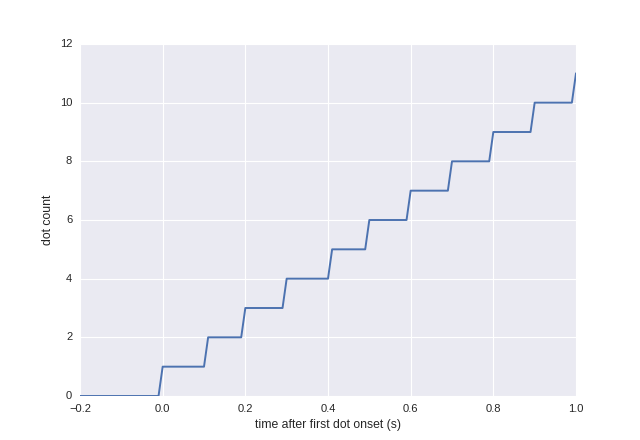

In [38]:
times = np.linspace(-0.2, 1, 121)
dotcount = lambda t: np.fmax(np.floor(t * 10) + 1, 0)
plt.figure()
plt.plot(times, dotcount(times))
plt.xlabel('time after first dot onset (s)')
plt.ylabel('dot count');

## Creating a trial regressor and comparison to accumulated evidence
The corresponding trial regressor is rather daft, because for any given time point it is constant across trials! I can, therefore, stop any subsequent analysis, because correlation of a constant with a varying signal is 0, or undefined. Only in the sequential analysis where I chain regressors associated with different time points, there is variance across the dot count regressor and I may see a correlation. I only need to check a single time point in this analysis, because the dot count regressor increments in the same way throughout the whole trial and the offset is irrelevant for the correlation.

In [42]:
t = 0.12
N = 480

pearsonr = pd.DataFrame(
    [scipy.stats.pearsonr(np.r_[np.full(N, dotcount(t)),
                                np.full(N, dotcount(t+0.1)),
                                np.full(N, dotcount(t+0.2))], 
                          DM.loc[sub].stack().reorder_levels([1, 0]).sort_index())
     for sub in subjects], 
    index=subjects, 
    columns=['corrcoef', 'pval'])
pearsonr['mlog10p'] = -np.log10(pearsonr.pval)

<IPython.core.display.Javascript object>


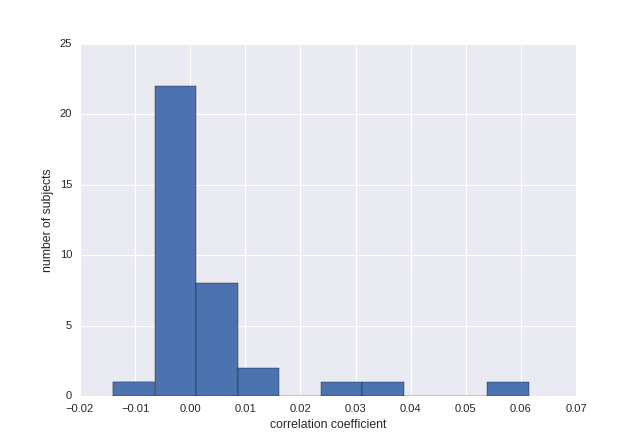

In [45]:
plt.figure()
plt.hist(pearsonr.corrcoef);
plt.xlabel('correlation coefficient');
plt.ylabel('number of subjects');

## Conclusion
It is no surprise that the dot count regressor is unrelated to the accumulated evidence regressor, simply because the dot counts do not vary across trials.